Shape of llm_df: (1472, 76)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Shape of encoded_messages: (2020, 512)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of high-level concept clusters for zero Jaccard: 7
Number of high-level concept clusters for non-zero Jaccard: 3


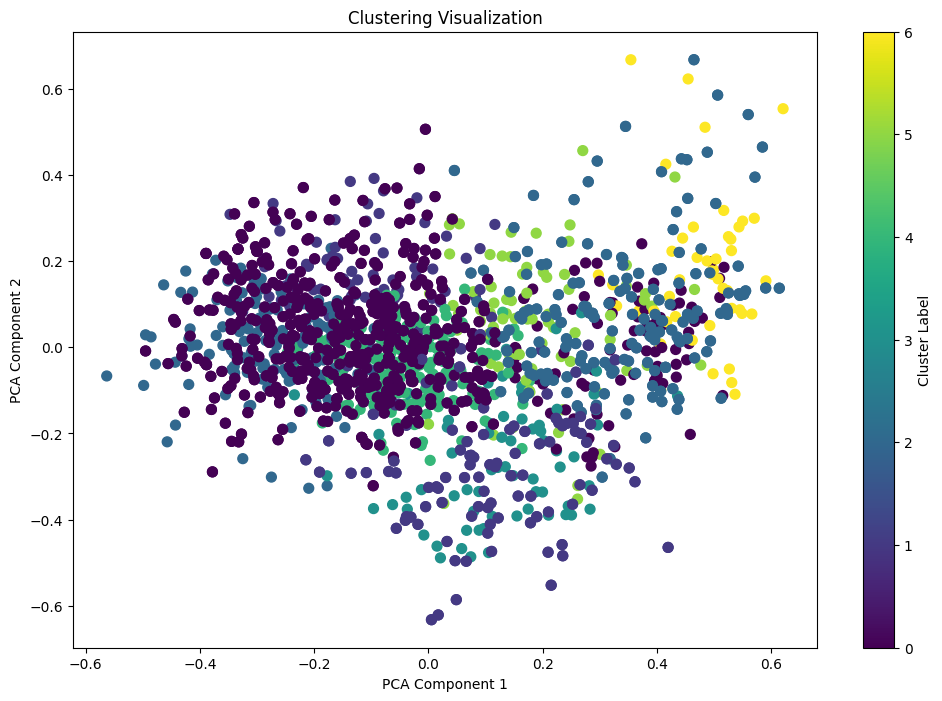

In [ ]:
# Importing
import pandas as pd
from transformers import T5Tokenizer, T5EncoderModel
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the CSV files
llm_df = pd.read_csv('LLM_binary_complete.csv')
ushahidi_df = pd.read_csv('Ushahidi_Message.csv')

# 1. Separate Jaccard scores into Zero and Non-zero groups
jaccard_columns = ['Jaccard_60%', 'Jaccard_80%', 'Jaccard_100%']

for col in jaccard_columns:
    llm_df[f'{col}_Zero'] = (llm_df[col] == 0).astype(int)
    llm_df[f'{col}_Non_Zero'] = (llm_df[col] != 0).astype(int)

print(f"Shape of llm_df: {llm_df.shape}")

# 2. Encode the messages using T5EncoderModel
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5EncoderModel.from_pretrained('t5-small')

def encode_message(message):
    inputs = tokenizer(message, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs.input_ids
    outputs = model(input_ids=input_ids)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

encoded_messages = []
for message in ushahidi_df['DESCRIPTION']:
    encoded_messages.append(encode_message(message))

# Convert to NumPy array
encoded_messages = np.vstack(encoded_messages)  # Convert list of arrays to a 2D array

# Debugging: Check the shape of encoded_messages
print(f"Shape of encoded_messages: {encoded_messages.shape}")

# Separate indices based on Jaccard scores
zero_jaccard_indices = llm_df.loc[llm_df[['Jaccard_60%_Zero', 'Jaccard_80%_Zero', 'Jaccard_100%_Zero']].any(axis=1)].index
non_zero_jaccard_indices = llm_df.loc[llm_df[['Jaccard_60%_Non_Zero', 'Jaccard_80%_Non_Zero', 'Jaccard_100%_Non_Zero']].any(axis=1)].index

# Ensure indices are within bounds of ushahidi_df
zero_jaccard_indices = [i for i in zero_jaccard_indices if i < len(ushahidi_df)]
non_zero_jaccard_indices = [i for i in non_zero_jaccard_indices if i < len(ushahidi_df)]

# Split encoded messages into zero and non-zero Jaccard groups
encoded_zero_jaccard = encoded_messages[zero_jaccard_indices]
encoded_non_zero_jaccard = encoded_messages[non_zero_jaccard_indices]

# 3. Cluster zero Jaccard messages
kmeans_zero_jaccard = KMeans(n_clusters=7, random_state=42)
ushahidi_df.loc[zero_jaccard_indices, 'Cluster'] = kmeans_zero_jaccard.fit_predict(encoded_zero_jaccard)

# 4. Cluster non-zero Jaccard messages
kmeans_non_zero_jaccard = KMeans(n_clusters=3, random_state=42)
ushahidi_df.loc[non_zero_jaccard_indices, 'Cluster'] = kmeans_non_zero_jaccard.fit_predict(encoded_non_zero_jaccard)

# Debugging: Check cluster counts
print(f"Number of high-level concept clusters for zero Jaccard: {ushahidi_df.loc[zero_jaccard_indices, 'Cluster'].nunique()}")
print(f"Number of high-level concept clusters for non-zero Jaccard: {ushahidi_df.loc[non_zero_jaccard_indices, 'Cluster'].nunique()}")

# 5. Dimensionality Reduction and Visualization
combined_encoded_messages = np.vstack((encoded_zero_jaccard, encoded_non_zero_jaccard))
combined_clusters = np.concatenate((
    ushahidi_df.loc[zero_jaccard_indices, 'Cluster'].values,
    ushahidi_df.loc[non_zero_jaccard_indices, 'Cluster'].values
))

# Using PCA to reduce the dimensionality to 2D
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(combined_encoded_messages)

# Create a scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=combined_clusters, cmap='viridis', s=50)
plt.colorbar(scatter, label='Cluster Label')
plt.title('Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()